<a href="https://colab.research.google.com/github/plooowry/Imperial_MLandAI_Cert/blob/main/Deterrence_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

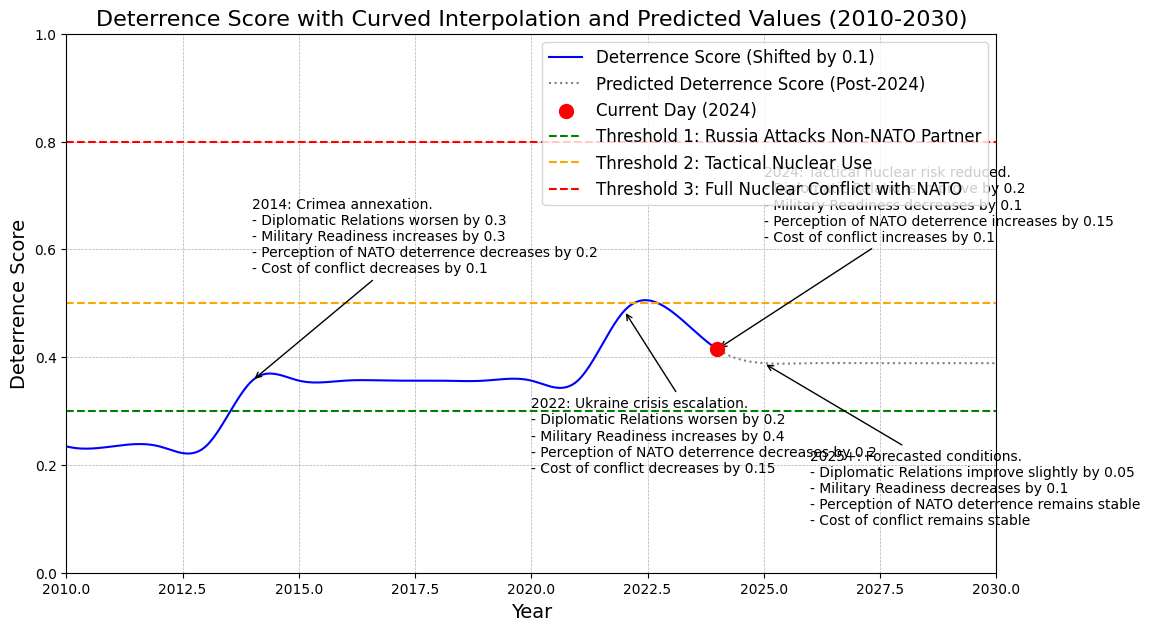

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Define the weighted formula to calculate the deterrence score
def calculate_deterrence_score(df, weights):
    """
    Calculate the deterrence score based on the DataFrame of variables and weights.
    """
    D_s = (weights['w1'] * df['MR'] +
           weights['w2'] * (1 - df['DR']) +
           weights['w3'] * (1 - df['P'])) / (weights['w4'] * df['C'] + 1)
    return np.clip(D_s, 0, 0.8)  # Clip to prevent exceeding 0.8

# Function to apply events that impact variables
def apply_events(df, events):
    """
    Update variables in the DataFrame based on events, ignoring the 'description' key.
    """
    for year, changes in events.items():
        for variable, change in changes.items():
            if variable != 'description':  # Skip the 'description' key
                df.loc[df['Year'] >= year, variable] += change
    return df

# Define weights for each factor
weights = {
    'w1': 0.2,  # Military Readiness
    'w2': 0.2,  # Diplomatic Relations
    'w3': 0.1,  # Perception of NATO's Deterrence
    'w4': 0.2   # Cost of Conflict
}

# Initialize variables for the years 2010 to 2030
years = np.arange(2010, 2031)
data = {
    'Year': years,
    'MR': 0.4,  # Military Readiness (moderate)
    'DR': 0.7,  # Diplomatic Relations (fairly good before Crimea)
    'P': 0.8,   # Perception of NATO’s Deterrence (strong before Crimea)
    'C': 0.95   # Cost of Conflict (high)
}

df = pd.DataFrame(data)

# Define events that impact variables with detailed descriptions
events = {
    2014: {
        'description': "2014: Crimea annexation.\n- Diplomatic Relations worsen by 0.3\n- Military Readiness increases by 0.3\n- Perception of NATO deterrence decreases by 0.2\n- Cost of conflict decreases by 0.1",
        'DR': -0.3,  # Worsen diplomatic relations
        'MR': 0.3,   # Increase military readiness
        'P': -0.2,   # Weaken perception of NATO deterrence
        'C': -0.1    # Decrease cost of conflict
    },
    2022: {
        'description': "2022: Ukraine crisis escalation.\n- Diplomatic Relations worsen by 0.2\n- Military Readiness increases by 0.4\n- Perception of NATO deterrence decreases by 0.2\n- Cost of conflict decreases by 0.15",
        'DR': -0.2,
        'MR': 0.4,
        'P': -0.2,
        'C': -0.15
    },
    2024: {
        'description': "2024: Tactical nuclear risk reduced.\n- Diplomatic Relations improve by 0.2\n- Military Readiness decreases by 0.1\n- Perception of NATO deterrence increases by 0.15\n- Cost of conflict increases by 0.1",
        'MR': -0.1,  # Decrease military readiness
        'DR': 0.2,   # Improve diplomatic relations
        'P': 0.15,   # Improve perception of NATO deterrence
        'C': 0.1     # Increase cost of conflict
    },
    2025: {
        'description': "2025+: Forecasted conditions.\n- Diplomatic Relations improve slightly by 0.05\n- Military Readiness decreases by 0.1\n- Perception of NATO deterrence remains stable\n- Cost of conflict remains stable",
        'MR': -0.1,  # Slightly reduced military readiness
        'DR': 0.05,  # Slightly improved diplomatic relations
        'P': 0.0,    # Perception remains stable
        'C': 0.0     # Cost remains stable
    }
}

# Apply events to the DataFrame
df = apply_events(df, events)

# Calculate the deterrence scores
df['Deterrence_Score'] = calculate_deterrence_score(df, weights)

# Perform cubic spline interpolation for smooth curves
cs = CubicSpline(df['Year'], df['Deterrence_Score'] + 0.1)  # Shift the curve by 0.1
years_interpolated = np.linspace(2010, 2030, 500)
deterrence_interpolated = np.clip(cs(years_interpolated), 0, 0.8)  # Clip to max 0.8

# Plotting
plt.figure(figsize=(12, 7))

# Plot interpolated deterrence scores before 2024 as a solid line
plt.plot(years_interpolated[years_interpolated <= 2024],
         deterrence_interpolated[years_interpolated <= 2024],
         label='Deterrence Score (Shifted by 0.1)', color='blue')

# Plot interpolated deterrence scores after 2024 as a dotted line
plt.plot(years_interpolated[years_interpolated > 2024],
         deterrence_interpolated[years_interpolated > 2024],
         linestyle=':', color='grey', label='Predicted Deterrence Score (Post-2024)')

# Highlight current day (2024) with a red circle
current_year = 2024
current_score = cs(current_year)
plt.scatter([current_year], [current_score], color='red', s=100, zorder=5, label='Current Day (2024)')

# Add horizontal threshold lines
plt.axhline(0.3, color='green', linestyle='--', label='Threshold 1: Russia Attacks Non-NATO Partner')
plt.axhline(0.5, color='orange', linestyle='--', label='Threshold 2: Tactical Nuclear Use')
plt.axhline(0.8, color='red', linestyle='--', label='Threshold 3: Full Nuclear Conflict with NATO')

# Annotate significant events with detailed descriptions and adjusted positions
plt.annotate(events[2014]['description'], xy=(2014, cs(2014)),
             xytext=(2014, cs(2014) + 0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(events[2022]['description'], xy=(2022, cs(2022)),
             xytext=(2022 - 2, cs(2022) - 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(events[2024]['description'], xy=(2024, cs(2024)),
             xytext=(2024 + 1, cs(2024) + 0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(events[2025]['description'], xy=(2025, cs(2025)),
             xytext=(2025 + 1, cs(2025) - 0.3), arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set y-axis limits
plt.ylim(0, 1)

# Set x-axis limits
plt.xlim(2010, 2030)

# Label axes and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Deterrence Score', fontsize=14)
plt.title('Deterrence Score with Curved Interpolation and Predicted Values (2010-2030)', fontsize=16)

# Display legend
plt.legend(fontsize=12, loc='upper right')

# Enable grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()